In [13]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import string
import random
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from matplotlib import pyplot
from gensim.models import KeyedVectors

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gaming\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
pip install gensim

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 24.0/24.0 MB 2.6 MB/s eta 0:00:00
     -------------------------------------- 983.8/983.8 kB 3.9 MB/s eta 0:00:00
     ---------------------------------------- 58.4/58.4 kB 3.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
# Reading the file
df = pd.read_csv("data.csv")

In [3]:
#Reading the first five records
df.head()

,Unnamed: 0.1,Desc,Unnamed: 0,author,genre,image_link,rating,title
0,0,We know that power is shifting: From West to E...,0.0,Moisés Naím,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.63,The End of Power: From Boardrooms to Battlefie...
1,1,Following the success of The Accidental Billio...,1.0,Blake J. Harris,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.94,"Console Wars: Sega, Nintendo, and the Battle t..."
2,2,How to tap the power of social software and ne...,2.0,Chris Brogan,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.78,Trust Agents: Using the Web to Build Influence...
3,3,William J. Bernstein is an American financial ...,3.0,William J. Bernstein,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.20,The Four Pillars of Investing
4,4,Amazing book. And I joined Steve Jobs and many...,4.0,Akio Morita,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.05,Made in Japan: Akio Morita and Sony


In [5]:
#Checking the shape of the file
df.shape

(2382, 8)

<AxesSubplot:>

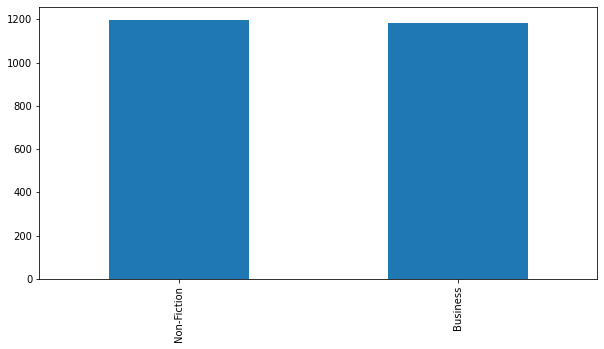

In [6]:
# Genre distribution
df['genre'].value_counts().plot(x = 'genre', y ='count', kind = 'bar', figsize = (10,5))

In [9]:
# Printing the book title and description randomly
print(df['title'][2])
df['Desc'][2]

Trust Agents: Using the Web to Build Influence, Improve Reputation, and Earn Trust


'How to tap the power of social software and networks to build your business In Trust Agents,  two social media veterans show you how to tap into the power of social networks to build your brand\'s influence, reputation, and, of course, profits. Today\'s online influencers are web natives who trade in trust, reputation, and relationships, using social media to accrue the influence that builds up or brings down businesses online.The book shows how people use online social tools to build networks of influence and how you can use those networks to positively impact your business. Because trust is key to building online reputations, those who traffic in it are "trust agents," the key people your business needs on its side.Delivers actionable steps and case studies that show how social media can positively impact your business Written by authors with over ten years of online media experience Shows you how to build and wield influence online to benefit your brand Combines high-level theory w

In [14]:
#Utitlity functions for removing ASCII characters, converting lower case, removing stop words, html and punctuation from description

def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

In [15]:
df['Desc'] = df['Desc'].astype(str)

In [16]:
df['cleaned'] = df['Desc'].apply(_removeNonAscii)

df['cleaned'] = df.cleaned.apply(func = make_lower_case)
df['cleaned'] = df.cleaned.apply(func = remove_stop_words)
df['cleaned'] = df.cleaned.apply(func=remove_punctuation)
df['cleaned'] = df.cleaned.apply(func=remove_html)

<AxesSubplot:title={'center':'Word Count Distribution for book descriptions'}, ylabel='Frequency'>

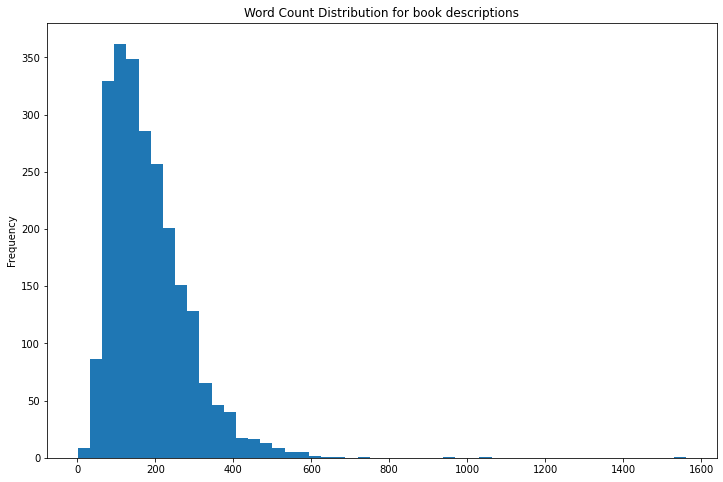

In [21]:
# Calculating the word count for book description
df['word_count'] = df['Desc'].apply(lambda x: len(str(x).split()))
# Plotting the word count
df['word_count'].plot(
    kind='hist',
    bins = 50,
    figsize = (12,8),title='Word Count Distribution for book descriptions')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Gaming\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


<AxesSubplot:title={'center':'Top 20 Part-of-speech tagging for comments'}>

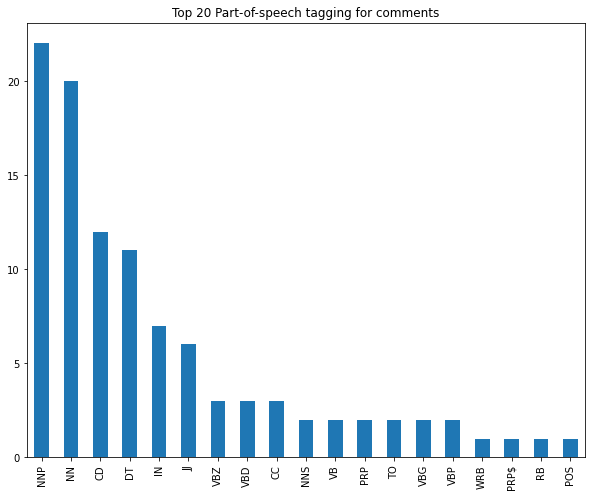

In [27]:
from textblob import TextBlob
import nltk
nltk.download('averaged_perceptron_tagger')
blob = TextBlob(str(df['Desc']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]
pos_df.plot(kind = 'bar', figsize=(10, 8), title = "Top 20 Part-of-speech tagging for comments")

<AxesSubplot:title={'center':'Bigram disribution for the top 20 words in the book description'}, xlabel='bigram'>

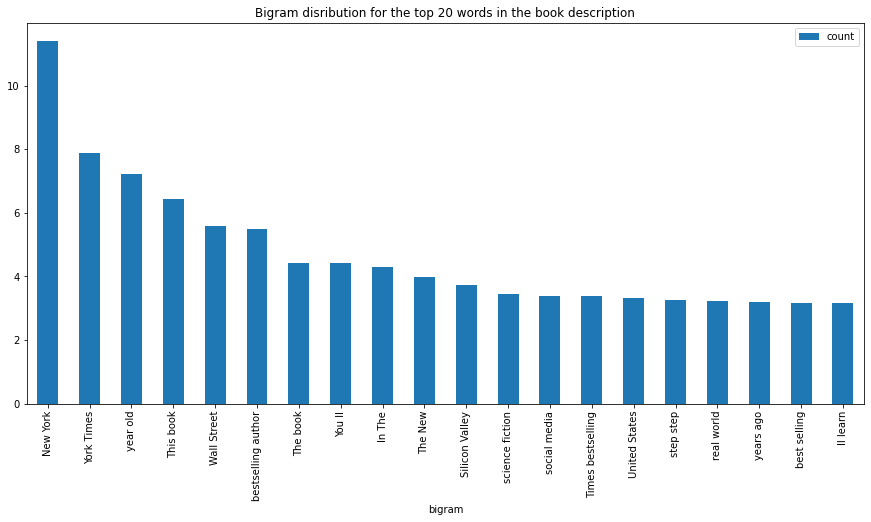

In [28]:
#Converting text descriptions into vectors using TF-IDF using Bigram
tf = TfidfVectorizer(ngram_range=(2, 2), stop_words='english', lowercase = False)
tfidf_matrix = tf.fit_transform(df['Desc'])
total_words = tfidf_matrix.sum(axis=0) 
#Finding the word frequency
freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
freq =sorted(freq, key = lambda x: x[1], reverse=True)
#converting into dataframe 
bigram = pd.DataFrame(freq)
bigram.rename(columns = {0:'bigram', 1: 'count'}, inplace = True) 
#Taking first 20 records
bigram = bigram.head(20)
#Plotting the bigram distribution
bigram.plot(x ='bigram', y='count', kind = 'bar', title = "Bigram disribution for the top 20 words in the book description", figsize = (15,7), )

<AxesSubplot:title={'center':'Bigram disribution for the top 20 words in the book description'}, xlabel='trigram'>

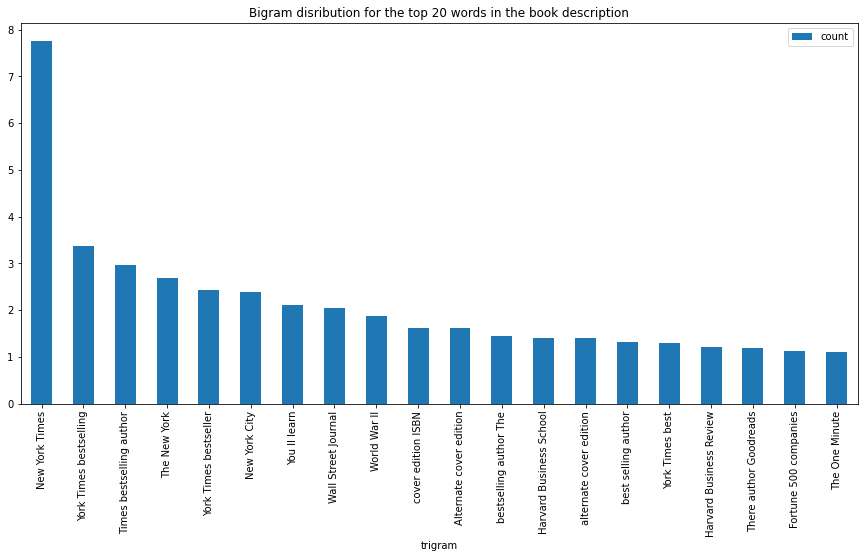

In [29]:
#Converting text descriptions into vectors using TF-IDF using Trigram
tf = TfidfVectorizer(ngram_range=(3, 3), stop_words='english', lowercase = False)
tfidf_matrix = tf.fit_transform(df['Desc'])
total_words = tfidf_matrix.sum(axis=0) 
#Finding the word frequency
freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
freq =sorted(freq, key = lambda x: x[1], reverse=True)
#converting into dataframe 
trigram = pd.DataFrame(freq)
trigram.rename(columns = {0:'trigram', 1: 'count'}, inplace = True) 
#Taking first 20 records
trigram = trigram.head(20)
#Plotting the trigramn distribution
trigram.plot(x ='trigram', y='count', kind = 'bar', title = "Bigram disribution for the top 20 words in the book description", figsize = (15,7), )

In [40]:
data = df.loc[df['genre'] == "Business"]
data

,Unnamed: 0.1,Desc,Unnamed: 0,author,genre,image_link,rating,title,cleaned,word_count
0,0,We know that power is shifting: From West to E...,0.0,Moisés Naím,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.63,The End of Power: From Boardrooms to Battlefie...,know power shifting west east north south pres...,291
1,1,Following the success of The Accidental Billio...,1.0,Blake J. Harris,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.94,"Console Wars: Sega, Nintendo, and the Battle t...",following success accidental billionaires mone...,248
2,2,How to tap the power of social software and ne...,2.0,Chris Brogan,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.78,Trust Agents: Using the Web to Build Influence...,tap power social software networks build busin...,191
3,3,William J. Bernstein is an American financial ...,3.0,William J. Bernstein,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.20,The Four Pillars of Investing,william j bernstein american financial theoris...,41
4,4,Amazing book. And I joined Steve Jobs and many...,4.0,Akio Morita,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.05,Made in Japan: Akio Morita and Sony,amazing book joined steve jobs many akio morit...,82
...,...,...,...,...,...,...,...,...,...,...
1180,1188,Barely one in a hundred businesspeople knows t...,1189.0,William D. Cohan,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.93,House of Cards: A Tale of Hubris and Wretched ...,barely one hundred businesspeople knows facts ...,257
1181,1189,We know that power is shifting: From West to E...,1190.0,Jordan Belfort,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.72,The Wolf of Wall Street,know power shifting west east north south pres...,291
1182,1190,Following the success of The Accidental Billio...,1191.0,Peter Lynch,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.03,Beating the Street,following success accidental billionaires mone...,248
1183,1191,How to tap the power of social software and ne...,1192.0,Jane Mayer,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.33,Dark Money: The Hidden History of the Billiona...,tap power social software networks build busin...,191


In [43]:
def recommend(title, genre):
    
    # Matching the genre with the dataset and reset the index
    data = df.loc[df['genre'] == genre]  
    data.reset_index(level = 0, inplace = True) 
  
    # Convert the index into series
    indices = pd.Series(data.index, index = data['title'])
    
    #Converting the book title into vectors and used bigram
    tf = TfidfVectorizer(analyzer='word', ngram_range=(2, 2), min_df = 1, stop_words='english')
    tfidf_matrix = tf.fit_transform(data['title'])
    
    # Calculating the similarity measures based on Cosine Similarity
    sg = cosine_similarity(tfidf_matrix, tfidf_matrix)
    
    # Get the index corresponding to original_title
       
    idx = indices[title]
# Get the pairwsie similarity scores 
    sig = list(enumerate(sg[idx]))
# Sort the books
    sig = sorted(sig, key=lambda x: x[1], reverse=True)
# Scores of the 5 most similar books 
    sig = sig[1:6]
# Book indicies
    movie_indices = [i[0] for i in sig]
   
    # Top 5 book recommendation
    rec = data[['title', 'image_link']].iloc[movie_indices]
       
    # It reads the top 5 recommend book url and print the images
    
    for i in rec['image_link']:
        response = requests.get(i)
        img = Image.open(BytesIO(response.content))
        plt.figure()
        print(plt.imshow(img))

AxesImage(54,36;334.8x217.44)
AxesImage(54,36;334.8x217.44)
AxesImage(54,36;334.8x217.44)
AxesImage(54,36;334.8x217.44)
AxesImage(54,36;334.8x217.44)


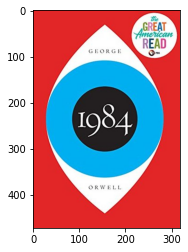

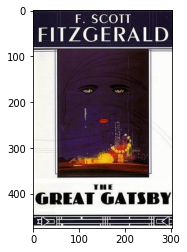

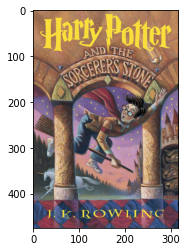

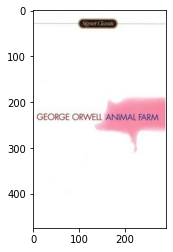

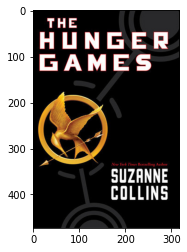

In [48]:
recommend("1984", "Non-Fiction")